# Imports

In [39]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor as lgbm

# Step 1: Data Collection and Preprocessing

## Data Collection

In [40]:
df = pd.read_csv("FINAL_DATASET.csv")

print(df.head())

/var/folders/hb/9n_ph5yj0491qld3nd7lpr900000gn/T/ipykernel_54950/2068735947.py:1: DtypeWarning: Columns (76,77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("FINAL_DATASET.csv")


   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2015        3      8           3          1  2015-08-03                WN   
1  2015        3      8           3          1  2015-08-03                WN   
2  2015        3      8           3          1  2015-08-03                WN   
3  2015        3      8           3          1  2015-08-03                WN   
4  2015        3      8           3          1  2015-08-03                WN   

   DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number  \
0                     19393                          WN      N7743B   
1                     19393                          WN      N525SW   
2                     19393                          WN      N528SW   
3                     19393                          WN      N523SW   
4                     19393                          WN      N515SW   

   Flight_Number_Reporting_Airline  OriginAirportID  OriginAirportSeqID  \
0                

In [41]:
df_grouped = df.groupby(['Origin', 'Dest', 'Month', 'DayOfWeek']).agg({
    'DepDelayMinutes': 'mean',
    'wspd': 'mean', 'tavg': 'mean', 'tmin': 'mean', 'tmax': 'mean', 'prcp': 'mean', 
    'snow': 'mean', 'wdir': 'mean', 'wspd': 'mean', 'wpgt': 'mean', 'pres': 'mean', 
}).reset_index()


## Data Preprocessing

### Converting to Imperial

In [42]:
import pandas as pd
df = pd.read_csv("FINAL_DATASET.csv")

# Temperature: Convert °C to °F
for col in ["tavg", "tmin", "tmax"]:
    if col in df.columns:
        df[col] = (df[col] * 9/5 + 32).round().astype("Int64")

# Precipitation & Snow: Convert mm to inches
for col in ["prcp", "snow"]:
    if col in df.columns:
        df[col] = df[col] / 25.4

# Wind Speed: Convert km/h to mph
if "wspd" in df.columns:
    df["wspd"] = df["wspd"] / 1.60934

# Pressure: Convert hPa to inHg
if "pres" in df.columns:
    df["pres"] = df["pres"] * 0.02953

print(df.head(1))

/var/folders/hb/9n_ph5yj0491qld3nd7lpr900000gn/T/ipykernel_54950/2290103901.py:2: DtypeWarning: Columns (76,77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("FINAL_DATASET.csv")


   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2015        3      8           3          1  2015-08-03                WN   

   DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number  \
0                     19393                          WN      N7743B   

   Flight_Number_Reporting_Airline  OriginAirportID  OriginAirportSeqID  \
0                           2066.0            12896             1289605   

   OriginCityMarketID Origin OriginCityName OriginState  OriginStateFips  \
0               32896    LBB    Lubbock, TX          TX               48   

  OriginStateName  OriginWac  DestAirportID  DestAirportSeqID  \
0           Texas         74          10423           1042302   

   DestCityMarketID Dest DestCityName DestState  DestStateFips DestStateName  \
0             30423  AUS   Austin, TX        TX             48         Texas   

   DestWac  CRSDepTime  DepTime  DepDelay  DepDelayMinutes  DepDel15  \
0       74         630    63

### Treating Missing Values

In [43]:
# Percentage NA by column
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
percent_na = df.isna().mean() * 100
print(percent_na.sort_values(ascending = False).head(75))

# Removing >3% missing cols and IATA Code column due to redundancy
cols_to_drop = percent_na[percent_na > 3].index
df = df.drop(columns = cols_to_drop)

print(f"\nDropped {len(cols_to_drop)} columns")
print("Remaining columns: ", len(df.columns))

# Printing percentage again
percent_na = df.isna().mean() * 100
print(percent_na.sort_values(ascending = False))

# Drop NaN rows
df.dropna(inplace=True)

Div3Airport             100.000000
Div3AirportSeqID        100.000000
Div3TotalGTime          100.000000
Div3LongestGTime        100.000000
Div3WheelsOff           100.000000
Div3TailNum             100.000000
Div4Airport             100.000000
Div4AirportID           100.000000
Div4AirportSeqID        100.000000
Div4WheelsOn            100.000000
Div4TotalGTime          100.000000
Div4LongestGTime        100.000000
Div4WheelsOff           100.000000
Div4TailNum             100.000000
Div5Airport             100.000000
Div5AirportID           100.000000
Div5AirportSeqID        100.000000
Div5WheelsOn            100.000000
Div5TotalGTime          100.000000
Div5LongestGTime        100.000000
Div5WheelsOff           100.000000
Div5TailNum             100.000000
Unnamed: 109            100.000000
wdir                    100.000000
Div3AirportID           100.000000
Div3WheelsOn            100.000000
tsun                     99.999711
Div2TailNum              99.999578
Div2WheelsOff       

### Heatmap After Removing Highly Correlated and Unwanted Variables

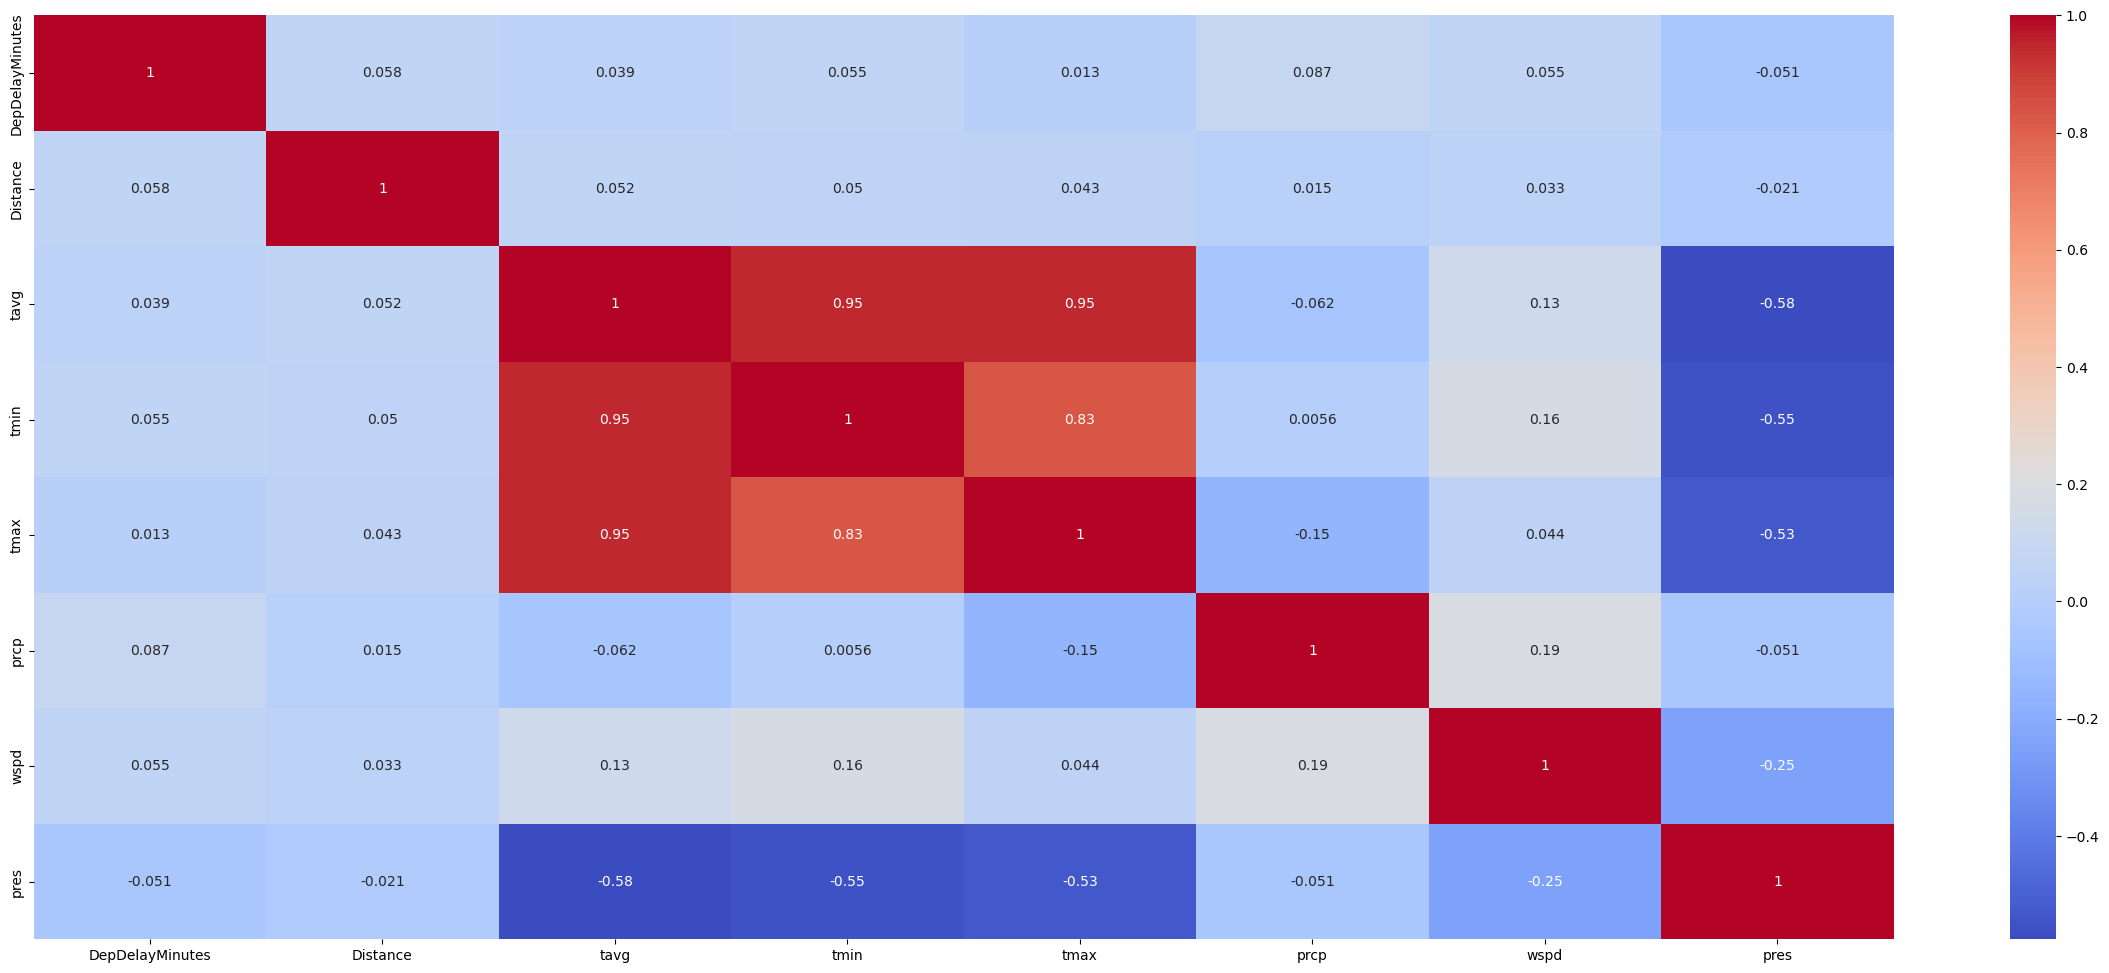

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# df = df.drop(columns = ['Tail_Number', 'ArrDel15', 'DepDelay', 'WheelsOn', 'WheelsOff', 'TaxiIn', 'TaxiOut', 'ArrTime', 'ArrDelay', 'ArrDelayMinutes', 'ArrivalDelayGroups', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'DistanceGroup'])
# df = df.drop(columns = ['DepDel15', 'DepartureDelayGroups'])
numeric_df = df.select_dtypes(include = ['number']).drop(columns = ['DepTime', 'Year', 'Quarter', 'DayofMonth', 'DivAirportLandings', 'DestAirportSeqID', 'Flights', 'OriginAirportID', 'OriginStateFips', 'DestWac', 'OriginWac', 'CRSDepTime', 'CRSArrTime', 'Cancelled', 'DestStateFips', 'DayOfWeek', 'Month', 'DOT_ID_Reporting_Airline', 'Flight_Number_Reporting_Airline', 'OriginCityMarketID', 'Diverted', 'OriginAirportSeqID', 'DestAirportID', 'DestCityMarketID'], errors = 'ignore')
plt.figure(figsize = (30, 12))
sns.heatmap(numeric_df.corr(method='spearman'), annot = True, cmap = "coolwarm")
plt.show()

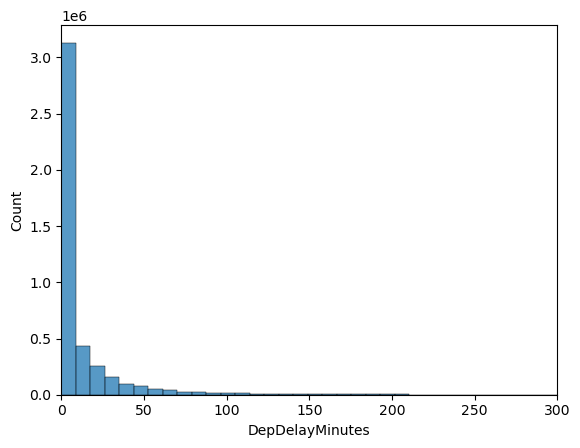

In [13]:
sns.histplot(df['DepDelayMinutes'], bins=100)
plt.xlim(0, 300)
plt.show()

The extreme right skew, combined with the low correlation coefficients, indicates we need to perform some feature engineering to help the model find relations between weather data and delay lengths.

In [14]:
percent_na = df.isna().mean() * 100
print(percent_na.sort_values(ascending = False))

DepTime                            1.899147
DepDelayMinutes                    1.899147
DepDel15                           1.899147
DepartureDelayGroups               1.899147
prcp                               0.458100
pres                               0.073344
tmax                               0.008974
tmin                               0.008974
wspd                               0.000844
tavg                               0.000244
DepTimeBlk                         0.000000
DestStateName                      0.000000
DestWac                            0.000000
CRSDepTime                         0.000000
Cancelled                          0.000000
CRSArrTime                         0.000000
ArrTimeBlk                         0.000000
Quarter                            0.000000
Diverted                           0.000000
Flights                            0.000000
Distance                           0.000000
DivAirportLandings                 0.000000
DestStateFips                   

### Delays Over Time

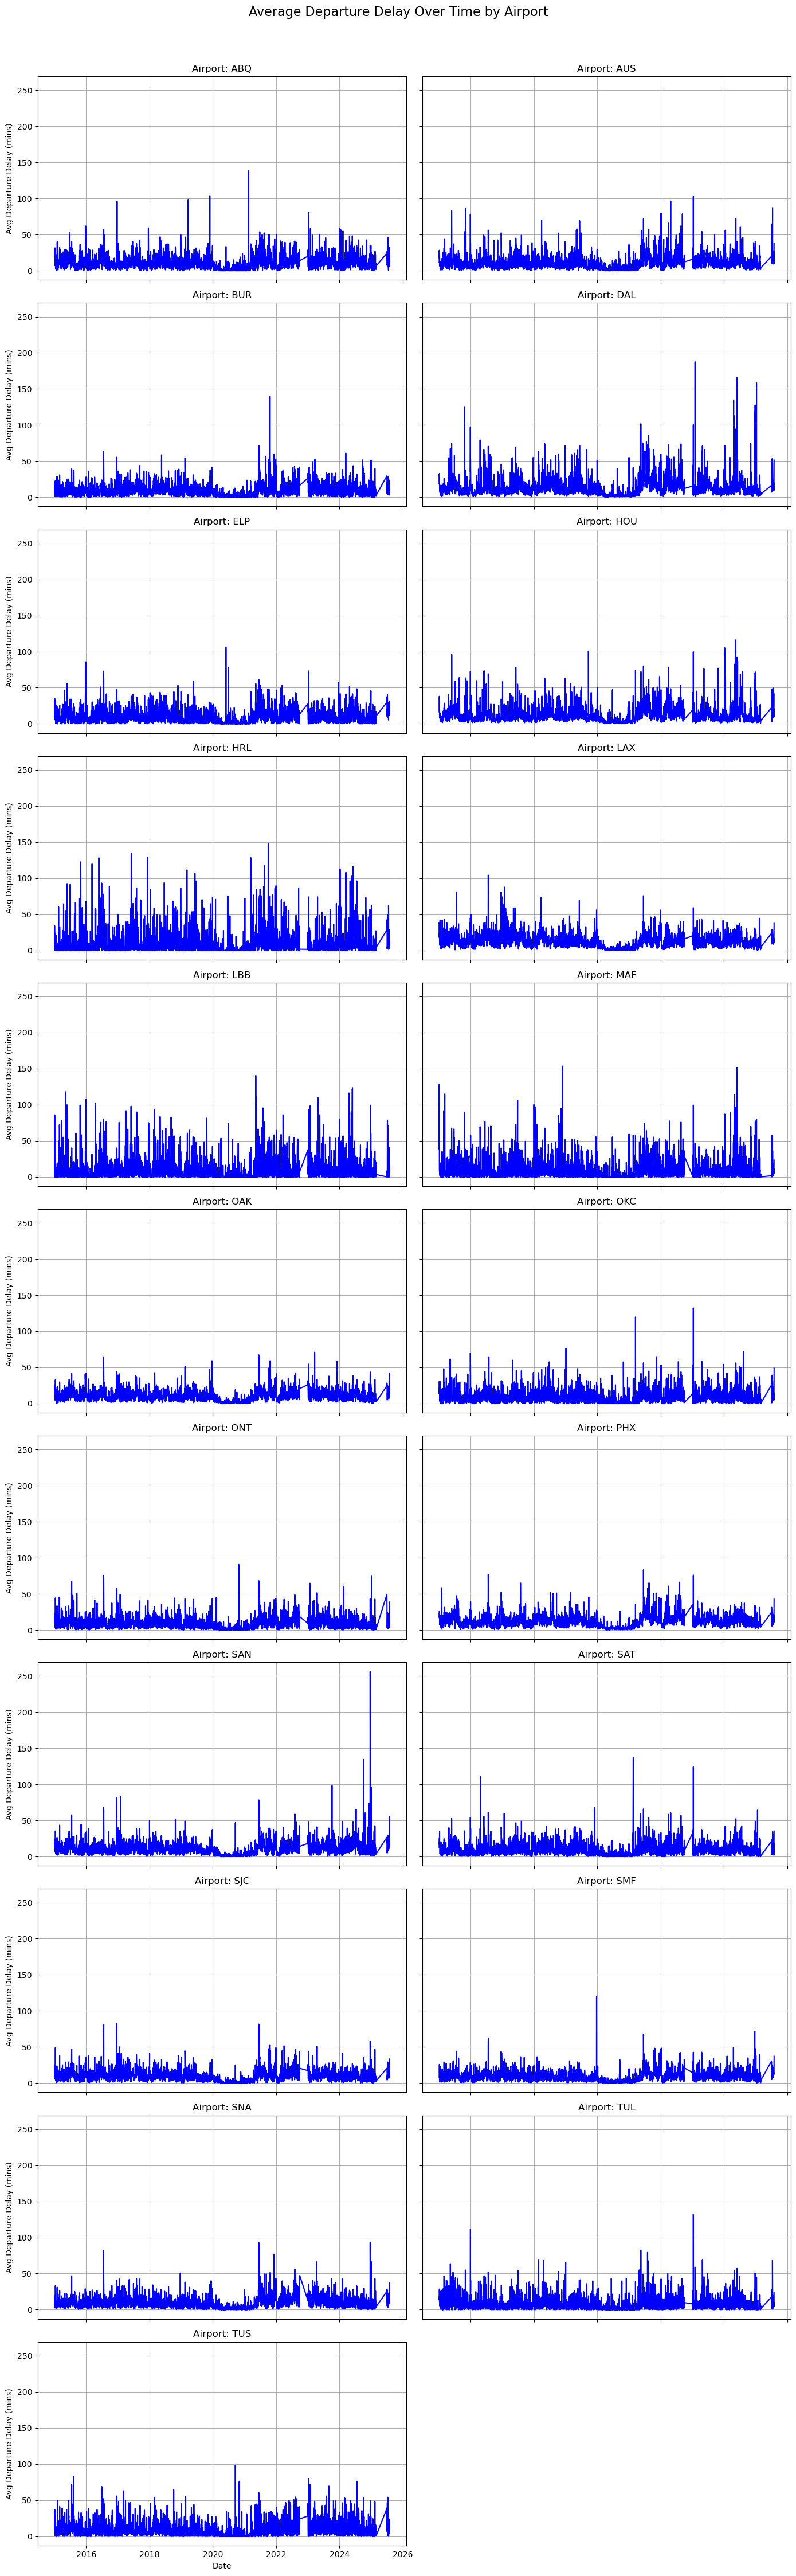

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure date column is datetime
df['FlightDate'] = pd.to_datetime(df['FlightDate'])

# ------------------------
# 2️⃣ Aggregate: average delay per day per airport
# ------------------------
avg_delay = (
    df.groupby(['FlightDate', 'Origin'])['DepDelayMinutes']
      .mean()
      .reset_index()
)

# ------------------------
# 3️⃣ Get unique airports
# ------------------------
airports = avg_delay['Origin'].unique()
num_airports = len(airports)

# ------------------------
# 4️⃣ Create subplots (one per airport)
# ------------------------
# Calculate number of rows and columns for subplots
cols = 2  # Adjust if you want more columns
rows = (num_airports + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, 4*rows), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to easily index

# Plot each airport
for i, airport in enumerate(airports):
    airport_data = avg_delay[avg_delay['Origin'] == airport]
    sns.lineplot(
        data=airport_data,
        x='FlightDate',
        y='DepDelayMinutes',
        ax=axes[i],
        color='blue'
    )
    axes[i].set_title(f"Airport: {airport}")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Avg Departure Delay (mins)")
    axes[i].grid(True)

# Remove unused subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Average Departure Delay Over Time by Airport", y=1.02, fontsize=16)
plt.show()


### Extra Features

In [44]:
# IsWeekend: 1 if the flight date is Saturday or Sunday, else 0
df['IsWeekend'] = df['DayOfWeek'].isin([6,7]).astype(int)

# IsHoliday: 1 if the flight date is a US federal holiday, else 0
df['FlightDate'] = pd.to_datetime(df['FlightDate'])

# Generate US holiday dates for your range
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df['FlightDate'].min(), end=df['FlightDate'].max())

df['IsHoliday'] = df['FlightDate'].isin(holidays)

# IsHolidayWindow: within 1 day before or after a holiday
holiday_window = pd.concat([
    pd.Series(holidays - pd.Timedelta(days=1)),
    pd.Series(holidays),
    pd.Series(holidays + pd.Timedelta(days=1))
])
df['IsHolidayWindow'] = df['FlightDate'].isin(holiday_window)

# NumDepartures: number of departures from the origin airport on that day
daily_departures = (
    df.groupby(['OriginAirportID', 'FlightDate'])
      .size()
      .rename('NumDepartures')
      .reset_index()
)

df = df.merge(daily_departures, on=['OriginAirportID', 'FlightDate'], how='left')

# Ensure Date column exists and is datetime
df['Date'] = pd.to_datetime(df['FlightDate'])

# Sort so rolling ops are time-consistent
df = df.sort_values(['OriginAirportID', 'Date'])

# --- Route-level rolling delay mean ---
df['Route'] = df['OriginAirportID'].astype(str) + '_' + df['DestAirportID'].astype(str)
df['RouteDelayMean_7d'] = (
    df.groupby('Route')['DepDelayMinutes']
      .transform(lambda x: x.shift().rolling(7, min_periods=1).mean())
)

# --- Airport-level (origin) rolling delay mean ---
df['OriginDelayMean_7d'] = (
    df.groupby('OriginAirportID')['DepDelayMinutes']
      .transform(lambda x: x.shift().rolling(7, min_periods=1).mean())
)

# --- Destination congestion indicator ---
df['DestArrivals_7d'] = (
    df.groupby('DestAirportID')['Flight_Number_Reporting_Airline']
      .transform(lambda x: x.shift().rolling(7, min_periods=1).count())
)

# --- Day-level departure volume (can help with congestion) ---
df['Departures_Today'] = df.groupby(['OriginAirportID', 'Date'])['Flight_Number_Reporting_Airline'].transform('count')

# --- Interaction features (useful for nonlinear models like LightGBM) ---
df['Dist_x_Wspd'] = df['Distance'] * df['wspd']
df['TempRange'] = df['tmax'] - df['tmin']
df['MonthxWeekday'] = df['Month'] * df['DayOfWeek']

# Replace any remaining NaN (from shift/rolling) with reasonable defaults
df.fillna({
    'RouteDelayMean_7d': 0,
    'OriginDelayMean_7d': 0,
    'DestArrivals_7d': 0
}, inplace=True)

## Step 2: Modeling

### LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3637
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 30
[LightGBM] [Info] Start training from score 11.819260
✅ Model Performance (LightGBM):
MAE:  13.64
RMSE: 25.61
R²:   0.116


/var/folders/hb/9n_ph5yj0491qld3nd7lpr900000gn/T/ipykernel_54950/2421677741.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances.head(15), palette='viridis')


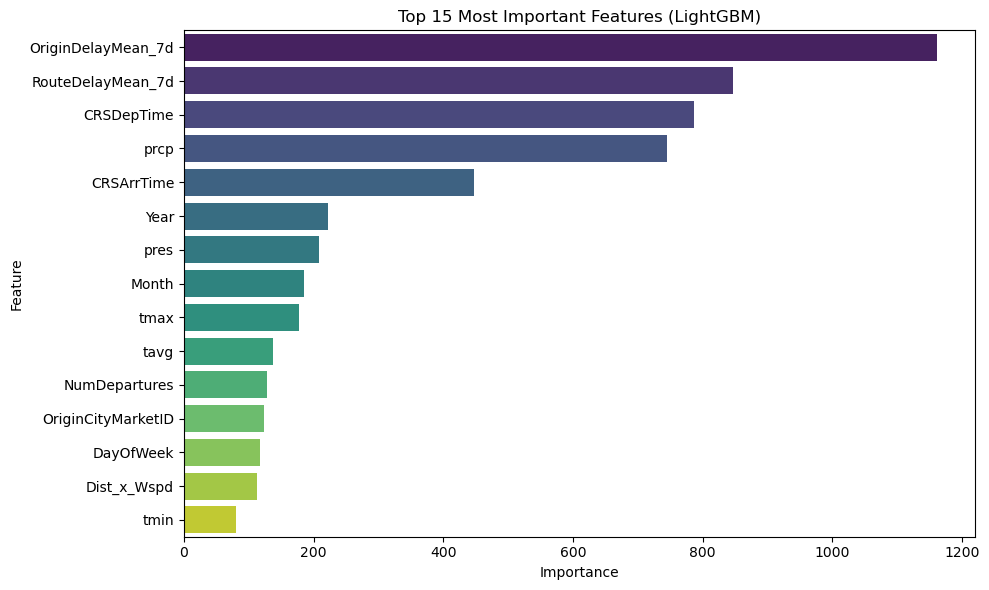

In [46]:
features = [
    'Year', 'Month', 'DayOfWeek', 'Flight_Number_Reporting_Airline',
    'OriginAirportID', 'OriginCityMarketID', 'OriginStateFips',
    'DestAirportID', 'DestCityMarketID', 'DestStateFips',
    'CRSDepTime', 'CRSArrTime', 'Distance', 'tavg', 'tmin', 'tmax',
    'prcp', 'wspd', 'pres', 'IsWeekend', 'IsHoliday', 'IsHolidayWindow',
    'NumDepartures', 'RouteDelayMean_7d', 'OriginDelayMean_7d', 
    'DestArrivals_7d', 'Departures_Today', 'Dist_x_Wspd', 'TempRange',
    'MonthxWeekday'
]
# One-hot encoded categorical variables
one_hot_cols = [col for col in df.columns if col.startswith('Origin_') or 
                col.startswith('Month_') or 
                col.startswith('DayOfWeek_') or 
                col.startswith('Dest_')]

target = 'DepDelayMinutes'

# Define X and y
X = df[features + one_hot_cols]
y = df[target]

# Optional: subsample for speed
'''X_sample = X.sample(500_000, random_state=42)
y_sample = y.loc[X_sample.index]

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)'''

df_model = df[features + one_hot_cols + [target]].dropna(subset=[target] + features)

# Now redefine X and y
X = df_model[features + one_hot_cols]
y = df_model[target]

# Sample + split
X_sample = X.sample(500_000, random_state=42)
y_sample = y.loc[X_sample.index]

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

# convert to lighter array to decrease memory usage
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# =========================
# 2️⃣ Train LightGBM
# =========================
lgb = lgbm(
    n_estimators=200,
    learning_rate=0.01,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=-1,          # no limit
    random_state=42,
    n_jobs=-1
)

lgb.fit(X_train, y_train)

# =========================
# 3️⃣ Evaluate model
# =========================
y_pred = lgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("✅ Model Performance (LightGBM):")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")

# =========================
# 4️⃣ Feature importance plot
# =========================
importances = pd.DataFrame({
    'Feature': X_sample.columns,
    'Importance': lgb.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances.head(15), palette='viridis')
plt.title("Top 15 Most Important Features (LightGBM)")
plt.tight_layout()
plt.show()

### Random Forest

In [32]:
# Select relevant numeric features
features = df.columns.tolist()
features.remove('DepDelayMinutes')

# One-hot encode categorical variables
one_hot_cols = [col for col in df.columns if col.startswith('Origin_') or col.startswith('Month_') or col.startswith('DayOfWeek_') or col.startswith('Dest_')]

# Target variable
target = 'DepDelayMinutes'

# Define X and y
X = df[features + one_hot_cols]
y = df[target]

X_sample = X.sample(500_000, random_state = 42)
y_sample = y.loc[X_sample.index]

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

# =========================
# 5️⃣ Train Random Forest
# =========================
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1
)
rf.fit(X_train, y_train)

# =========================
# 6️⃣ Evaluate model
# =========================
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("✅ Model Performance:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")

# =========================
# 7️⃣ Feature importance plot
# =========================
importances = pd.DataFrame({
    'Feature': X_sample.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances.head(15), palette='viridis')
plt.title("Top 15 Most Important Features (Random Forest)")
plt.tight_layout()
plt.show()

TypeError: Cannot cast DatetimeArray to dtype float32